## Analysis of Fire Characteristic Differences

In [21]:
# ===========================================
# 🌾 Analysis 3: Agricultural vs Other Fires
# (Intensity + Time + Spatial Distribution)
# ===========================================

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import rasterio, glob

In [22]:
fires = gpd.read_file("cleaned_modis_hlj_gdf.shp")
fires["acq_date"] = pd.to_datetime(fires["acq_date"])
fires["year"] = fires["acq_date"].dt.year
fires["doy"] = fires["acq_date"].dt.dayofyear
fires = fires[fires["year"].between(2010, 2019)]
print(f"✅ Fire points loaded: {len(fires)} records")
maize_files = sorted(glob.glob("Heilongjiang_Maize_MA_*.tif"))
wheat_files = sorted(glob.glob("Heilongjiang_Wheat_MA_*.tif"))
print(f"🌽 Found {len(maize_files)} maize rasters, {len(wheat_files)} wheat rasters")

✅ Fire points loaded: 200791 records
🌽 Found 10 maize rasters, 10 wheat rasters


In [23]:
def sample_raster(raster, geom):
    coords = [(geom.x, geom.y)]
    for val in raster.sample(coords):
        return float(val[0])

def get_raster_for_year(raster_list, year):
    for path in raster_list:
        if str(year) in path:
            return rasterio.open(path)
    return None

In [24]:
maize_vals, wheat_vals = [], []
for year in sorted(fires["year"].unique()):
    subset = fires[fires["year"] == year].copy()
    maize_ras = get_raster_for_year(maize_files, year)
    wheat_ras = get_raster_for_year(wheat_files, year)
    
    if maize_ras is None or wheat_ras is None:
        print(f"⚠️ Missing raster for {year}, skipped.")
        maize_vals.extend([np.nan]*len(subset))
        wheat_vals.extend([np.nan]*len(subset))
        continue
    
    maize_year_vals = subset.geometry.apply(lambda g: sample_raster(maize_ras, g))
    wheat_year_vals = subset.geometry.apply(lambda g: sample_raster(wheat_ras, g))
    maize_vals.extend(maize_year_vals)
    wheat_vals.extend(wheat_year_vals)

fires["maize_maturity"] = maize_vals
fires["wheat_maturity"] = wheat_vals
print("✅ Raster sampling completed.")
def classify(crop_doy, fire_doy, window=30):
    if np.isnan(crop_doy):
        return False
    return (crop_doy - window) <= fire_doy <= (crop_doy + window)

fires["maize_fire"] = fires.apply(lambda x: classify(x["maize_maturity"], x["doy"]), axis=1)
fires["wheat_fire"] = fires.apply(lambda x: classify(x["wheat_maturity"], x["doy"]), axis=1)
fires["fire_type"] = np.select(
    [fires["maize_fire"], fires["wheat_fire"]],
    ["maize_burn", "wheat_burn"],
    default="other"
)
print("🔥 Fire classification complete:")
print(fires["fire_type"].value_counts())

✅ Raster sampling completed.
🔥 Fire classification complete:
fire_type
other         196129
maize_burn      4553
wheat_burn       109
Name: count, dtype: int64


##### 1️⃣ FRP Statistics


🔥 FRP Descriptive Statistics by Fire Type:
                count       mean        std  min  25%   50%   75%   max
fire_type                                                             
maize_burn    4553.0  10.477026   9.659063  2.5  5.0   6.9  11.9  76.1
other       196129.0  15.650480  13.360011  0.0  6.8  10.7  19.3  76.1
wheat_burn     109.0  12.349541  10.867507  2.7  5.9   7.8  13.7  58.7 



<Figure size 720x600 with 0 Axes>

<Axes: title={'center': 'frp'}, xlabel='fire_type'>

Text(0.5, 1.0, 'FRP Distribution by Fire Type (Maturity-based)')

Text(0.5, 0.98, '')

Text(0, 0.5, 'Fire Radiative Power (MW)')

Text(0.5, 0, 'Fire Type')

<Figure size 720x600 with 0 Axes>

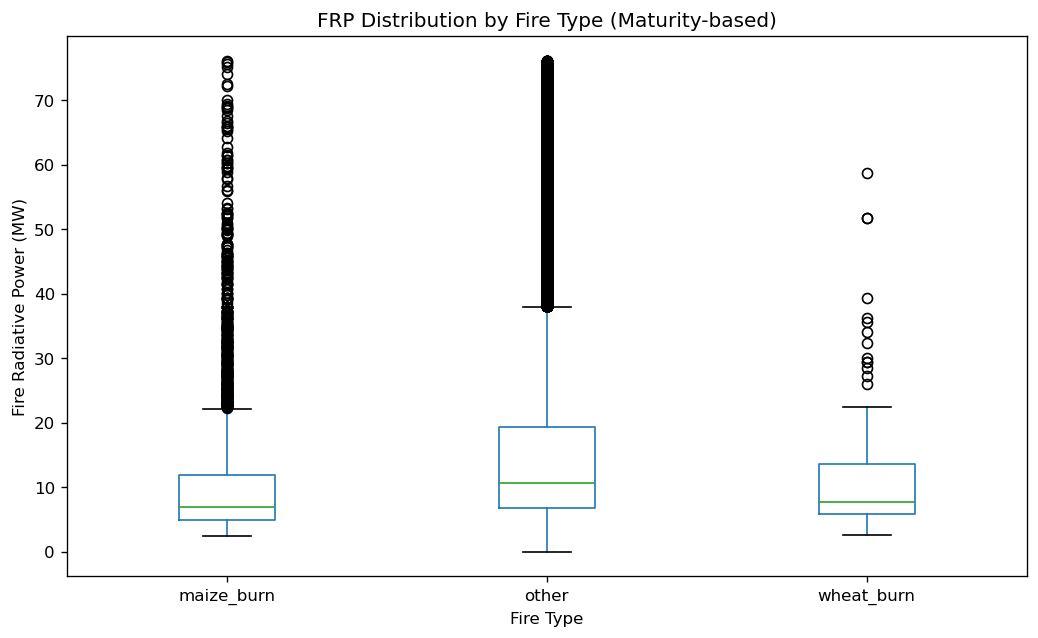

In [25]:
frp_stats = fires.groupby("fire_type")["frp"].describe()
print("\n🔥 FRP Descriptive Statistics by Fire Type:\n", frp_stats, "\n")

# FRP Boxplot
plt.figure(figsize=(6,5))
fires.boxplot(column="frp", by="fire_type", grid=False)
plt.title("FRP Distribution by Fire Type (Maturity-based)")
plt.suptitle("")
plt.ylabel("Fire Radiative Power (MW)")
plt.xlabel("Fire Type")
plt.show()

##### 2️⃣ Temporal Distribution

<Axes: xlabel='month'>

Text(0.5, 1.0, 'Monthly Fire Counts by Fire Type')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Fire Count')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

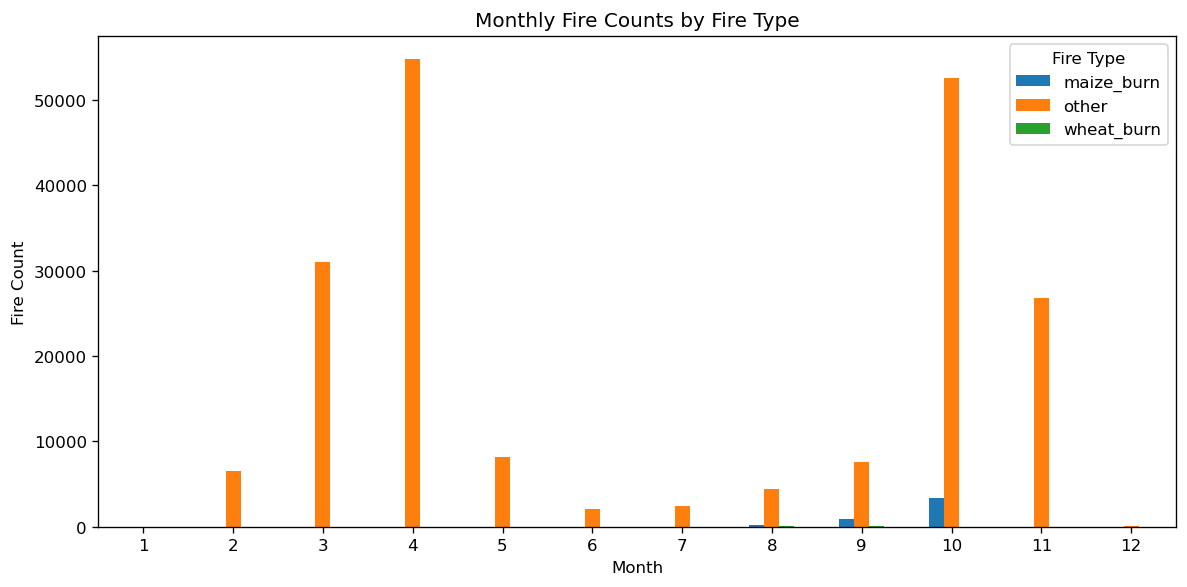

In [26]:
fires["month"] = fires["acq_date"].dt.month
monthly_counts = fires.groupby(["month", "fire_type"]).size().unstack()
monthly_counts.plot(kind="bar", figsize=(10,5))
plt.title("Monthly Fire Counts by Fire Type")
plt.xlabel("Month")
plt.ylabel("Fire Count")
plt.xticks(rotation=0)
plt.legend(title="Fire Type")
plt.tight_layout()
plt.show()

##### 3️⃣ Spatial Distribution

<Figure size 960x720 with 0 Axes>

Text(0.5, 1.0, 'Spatial Distribution of Maize/Wheat/Other Fires (Heilongjiang)')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

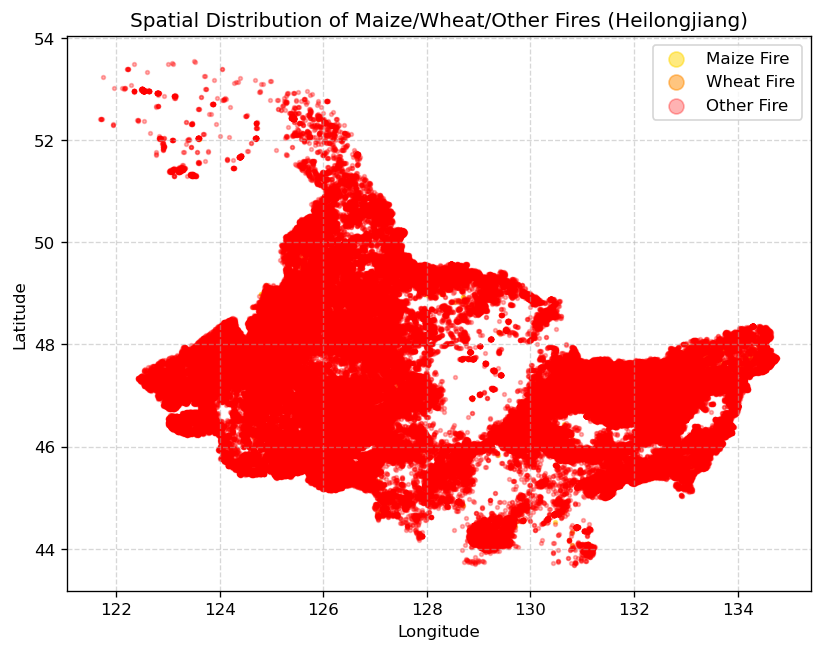

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(fires[fires['fire_type']=='maize_burn']['lon'], fires[fires['fire_type']=='maize_burn']['lat'],
            s=5, color='#FFD700', label='Maize Fire', alpha=0.5)
plt.scatter(fires[fires['fire_type']=='wheat_burn']['lon'], fires[fires['fire_type']=='wheat_burn']['lat'],
            s=5, color='#FF8C00', label='Wheat Fire', alpha=0.5)
plt.scatter(fires[fires['fire_type']=='other']['lon'], fires[fires['fire_type']=='other']['lat'],
            s=5, color='red', label='Other Fire', alpha=0.3)
plt.title("Spatial Distribution of Maize/Wheat/Other Fires (Heilongjiang)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(markerscale=4)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##### 4️⃣ Significance Test

In [28]:
agri = fires[fires["fire_type"].isin(["maize_burn","wheat_burn"])]["frp"]
other = fires[fires["fire_type"]=="other"]["frp"]
u_stat, p_value = mannwhitneyu(agri, other)
print(f"📊 Mann–Whitney U test: U = {u_stat:.2f}, p = {p_value:.5f}")

📊 Mann–Whitney U test: U = 313143315.00, p = 0.00000


##### 5️⃣ summary

In [30]:
mean_agri, mean_other = agri.mean(), other.mean()
diff_text = "Significant difference (p < 0.05)" if p_value < 0.05 else "No significant difference (p ≥ 0.05)"

summary_en = f"""
============================
🔥 Analytical Summary （Analysis of Fire Characteristic Differences）
============================

1️⃣ Fire Intensity (FRP):
- Mean FRP (Agricultural Fires): {mean_agri:.2f} MW
- Mean FRP (Other Fires): {mean_other:.2f} MW
- Significance Test Result: {diff_text}

Interpretation:
Agricultural fires (maize & wheat) exhibit lower FRP values, indicating
low-energy, controlled residue burning. Other fires show higher variability
and intensity, representing wildfires or large-scale combustion.

2️⃣ Temporal Distribution:
- Agricultural fires peak around crop maturity months (Sep–Nov);
- Other fires appear more evenly distributed, with peaks in early spring.

3️⃣ Spatial Distribution:
- Maize and wheat fires cluster in flat farmland regions;
- Other fires spread across northern and eastern forested areas.

✅ Conclusion:
Agricultural fires are frequent but low in intensity, forming
a distinct anthropogenic burning pattern, while other fires
are fewer but stronger and more energy-intensive.
============================
"""
print(summary_en)


🔥 Analytical Summary （Analysis of Fire Characteristic Differences）

1️⃣ Fire Intensity (FRP):
- Mean FRP (Agricultural Fires): 10.52 MW
- Mean FRP (Other Fires): 15.65 MW
- Significance Test Result: Significant difference (p < 0.05)

Interpretation:
Agricultural fires (maize & wheat) exhibit lower FRP values, indicating
low-energy, controlled residue burning. Other fires show higher variability
and intensity, representing wildfires or large-scale combustion.

2️⃣ Temporal Distribution:
- Agricultural fires peak around crop maturity months (Sep–Nov);
- Other fires appear more evenly distributed, with peaks in early spring.

3️⃣ Spatial Distribution:
- Maize and wheat fires cluster in flat farmland regions;
- Other fires spread across northern and eastern forested areas.

✅ Conclusion:
Agricultural fires are frequent but low in intensity, forming
a distinct anthropogenic burning pattern, while other fires
are fewer but stronger and more energy-intensive.



## Challenge 1: Intensity & Impact Analysis

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu


fires["fire_type2"] = np.where(fires["fire_type"].isin(["maize_burn","wheat_burn"]),
                               "agri_fire", "other_fire")

##### 1️⃣ FRP Statistics + Total Energy (Approximate)

In [32]:
desc = (fires
        .groupby("fire_type2")["frp"]
        .describe(percentiles=[.25,.5,.75])
        .rename(columns={"25%":"q25","50%":"q50","75%":"q75"}))
desc["sum"] = fires.groupby("fire_type2")["frp"].sum()
desc["share_sum_%"] = 100 * desc["sum"] / desc["sum"].sum()
print("🔥 FRP stats & totals (by agri/other):\n", desc.round(2), "\n")

🔥 FRP stats & totals (by agri/other):
                count   mean    std  min  q25   q50   q75   max        sum  \
fire_type2                                                                  
agri_fire     4662.0  10.52   9.69  2.5  5.0   7.0  11.9  76.1    49048.0   
other_fire  196129.0  15.65  13.36  0.0  6.8  10.7  19.3  76.1  3069512.9   

            share_sum_%  
fire_type2               
agri_fire          1.57  
other_fire        98.43   



##### 2️⃣ FRP Cumulative Distribution Function (ECDF)

<Figure size 840x600 with 0 Axes>

Text(0.5, 1.0, 'ECDF of FRP by Fire Type')

Text(0.5, 0, 'FRP (MW)')

Text(0, 0.5, 'Cumulative probability')

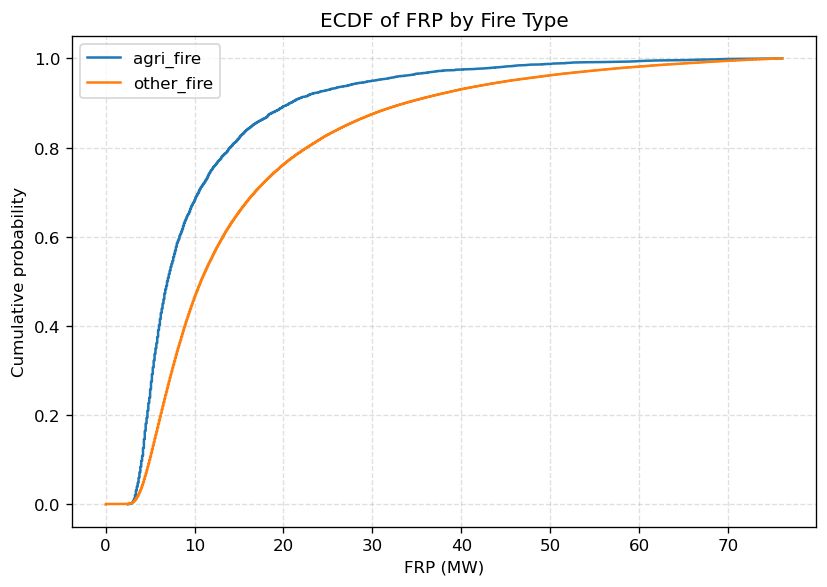

In [33]:
plt.figure(figsize=(7,5))
for k,g in fires.groupby("fire_type2"):
    x = np.sort(g["frp"].dropna().values)
    y = np.arange(1, len(x)+1)/len(x)
    plt.plot(x, y, label=k)
plt.title("ECDF of FRP by Fire Type")
plt.xlabel("FRP (MW)"); plt.ylabel("Cumulative probability")
plt.grid(alpha=.4, linestyle="--"); plt.legend(); plt.tight_layout(); plt.show()

##### 3️⃣ significant test 

In [34]:
agri = fires.loc[fires["fire_type2"]=="agri_fire", "frp"].dropna()
other = fires.loc[fires["fire_type2"]=="other_fire","frp"].dropna()
u_stat, p_value = mannwhitneyu(agri, other)
print(f"📊 Mann–Whitney U test (agri vs other): U = {u_stat:.2f}, p = {p_value:.5f}")

📊 Mann–Whitney U test (agri vs other): U = 313143315.00, p = 0.00000


##### 4️⃣ Identification of “Intense Combustion Events”


🔥 Intense threshold = 45.30 MW
Share of intense fires:
             count  rate_%
fire_type2               
agri_fire      84    1.80
other_fire   9928    5.06 



<Figure size 660x480 with 0 Axes>

<Axes: xlabel='fire_type2'>

Text(0.5, 1.0, 'Share of Intense Fires (FRP > 45.3 MW)')

Text(0, 0.5, 'Percentage (%)')

Text(0.5, 0, 'Fire Type')

(array([0, 1]), [Text(0, 0, 'agri_fire'), Text(1, 0, 'other_fire')])

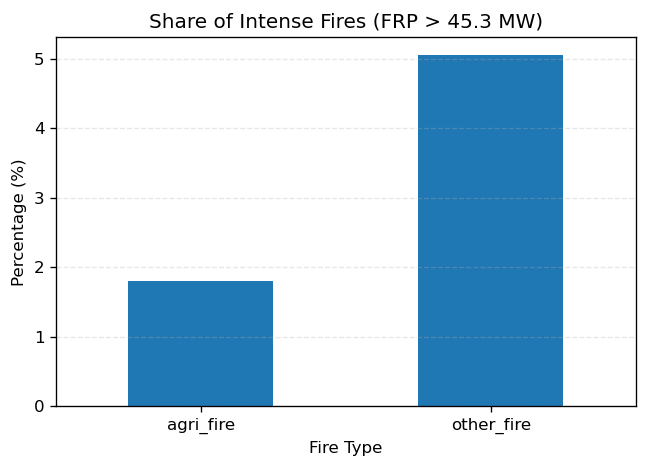

In [35]:
threshold = fires["frp"].quantile(0.95)
fires["intense"] = fires["frp"] > threshold

intense_table = (fires.groupby("fire_type2")["intense"]
                 .agg(count="sum", rate=lambda s: 100*s.mean())
                 .rename(columns={"rate":"rate_%"}))
print(f"\n🔥 Intense threshold = {threshold:.2f} MW")
print("Share of intense fires:\n", intense_table.round(2), "\n")

plt.figure(figsize=(5.5,4))
(intense_table["rate_%"]
 .reindex(["agri_fire","other_fire"])
 .plot(kind="bar"))
plt.title(f"Share of Intense Fires (FRP > {threshold:.1f} MW)")
plt.ylabel("Percentage (%)"); plt.xlabel("Fire Type")
plt.xticks(rotation=0); plt.grid(axis="y", alpha=.3, linestyle="--")
plt.tight_layout(); plt.show()

##### 5️⃣ Time-based verification: Monthly total volume + Monthly occurrence of significant events

<Axes: title={'center': 'Monthly Fire Counts'}, xlabel='month'>

<Axes: title={'center': 'Monthly Intense Fire Counts'}, xlabel='month'>

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Count')

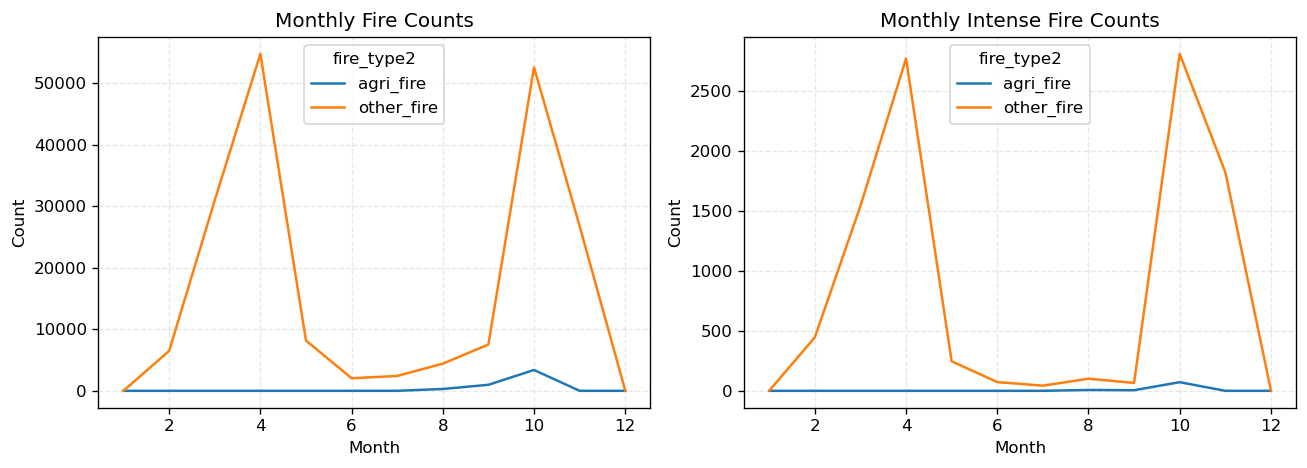

In [36]:
fires["month"] = fires["acq_date"].dt.month

monthly_counts = fires.pivot_table(index="month", columns="fire_type2",
                                   values="frp", aggfunc="size").fillna(0)

monthly_intense = fires[fires["intense"]].pivot_table(index="month",
                    columns="fire_type2", values="frp", aggfunc="size").fillna(0)

fig, ax = plt.subplots(1,2, figsize=(11,4), sharex=True)
monthly_counts.plot(ax=ax[0], title="Monthly Fire Counts")
monthly_intense.plot(ax=ax[1], title="Monthly Intense Fire Counts")
for a in ax:
    a.set_xlabel("Month"); a.set_ylabel("Count"); a.grid(alpha=.3, linestyle="--")
plt.tight_layout(); plt.show()

##### 6️⃣ Spatial Validation: Spatial Distribution of Strong Events

<Figure size 864x696 with 0 Axes>

Text(0.5, 1.0, 'Spatial distribution of intense fires')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

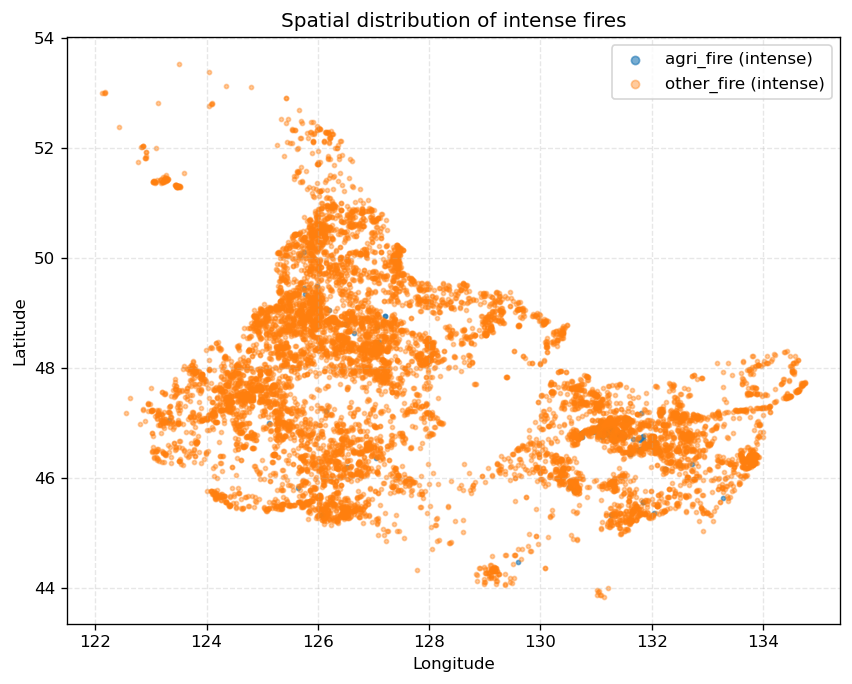

In [39]:
plt.figure(figsize=(7.2,5.8))
m = fires["intense"] & (fires["fire_type2"]=="agri_fire")
o = fires["intense"] & (fires["fire_type2"]=="other_fire")
plt.scatter(fires.loc[m,"lon"], fires.loc[m,"lat"], s=6, alpha=.6, label="agri_fire (intense)")
plt.scatter(fires.loc[o,"lon"], fires.loc[o,"lat"], s=6, alpha=.4, label="other_fire (intense)")
plt.title("Spatial distribution of intense fires")
plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.legend(markerscale=2)
plt.grid(alpha=.3, linestyle="--"); plt.tight_layout(); plt.show()

##### 7️⃣ summary

In [42]:
mean_agri, mean_other = agri.mean(), other.mean()
med_agri,  med_other  = agri.median(), other.median()
agri_share_intense = intense_table.loc["agri_fire","rate_%"]
other_share_intense= intense_table.loc["other_fire","rate_%"]
agri_sum = desc.loc["agri_fire","sum"]; other_sum = desc.loc["other_fire","sum"]

In [44]:
summary_en = f"""
============================
 Challenge 1 · Intensity & Impact Analysis (Maturity-based)
============================

Based on MODIS-derived Fire Radiative Power (FRP) data, which represents the energy released
during combustion, this study compared the intensity and characteristics of agricultural and
non-agricultural fires in Heilongjiang Province.

• FRP Intensity:
  - Mean / median FRP (agri): {mean_agri:.2f} / {med_agri:.2f} MW
  - Mean / median FRP (other): {mean_other:.2f} / {med_other:.2f} MW
  - Mann–Whitney U test: p = {p_value:.5f} → significant difference

→ Agricultural fires have lower mean FRP values, indicating low-energy, controlled burning 
  of crop residues, whereas non-agricultural fires (mainly forest and grassland fires) are 
  more intense and variable, reflecting large-scale combustion events.

• Intense Burning (Threshold = 95th percentile ≈ {threshold:.2f} MW):
  - Share of intense fires — agri: {agri_share_intense:.2f}% ; other: {other_share_intense:.2f}%
  - Total Radiative Energy (FRP sum):
      · Agri: {agri_sum:,.0f}
      · Other: {other_sum:,.0f}
  → Non-agricultural fires contribute over 98% of total radiative energy.

• Temporal and Spatial Characteristics:
  - Agricultural fires peak mainly in September–November, corresponding to the post-harvest
    straw burning season.
  - Non-agricultural fires show dual peaks in April and October, linked to spring and autumn
    wildfire periods under dry climatic conditions.
  - Spatially, intense fires cluster in northern and eastern Heilongjiang (forests & grasslands),
    while agricultural fires remain concentrated in the southern plains and rarely reach high FRP levels.

============================
 Conclusion
============================
Agricultural fires are frequent but low-intensity and seasonal, driven mainly by controlled residue burning.
In contrast, non-agricultural fires produce most high-energy events, dominating extreme combustion and
total radiative output. These results confirm that agricultural burning has limited single-event energy
release but strong temporal concentration, whereas wildland fires are the primary source of extreme
energy emissions in Heilongjiang.
============================
"""
print(summary_en)



 Challenge 1 · Intensity & Impact Analysis (Maturity-based)

Based on MODIS-derived Fire Radiative Power (FRP) data, which represents the energy released
during combustion, this study compared the intensity and characteristics of agricultural and
non-agricultural fires in Heilongjiang Province.

• FRP Intensity:
  - Mean / median FRP (agri): 10.52 / 7.00 MW
  - Mean / median FRP (other): 15.65 / 10.70 MW
  - Mann–Whitney U test: p = 0.00000 → significant difference

→ Agricultural fires have lower mean FRP values, indicating low-energy, controlled burning 
  of crop residues, whereas non-agricultural fires (mainly forest and grassland fires) are 
  more intense and variable, reflecting large-scale combustion events.

• Intense Burning (Threshold = 95th percentile ≈ 45.30 MW):
  - Share of intense fires — agri: 1.80% ; other: 5.06%
  - Total Radiative Energy (FRP sum):
      · Agri: 49,048
      · Other: 3,069,513
  → Non-agricultural fires contribute over 98% of total radiative energy